**Workflow**:
1. Extract contours and markers from xml files.
2. Reconstruct brains as a set of 3D arrays, one for each structure, based on contours.
3. Define a fixed brain. Align other brains to it. (Omitted.)
4. Load fixed brain and other brains that have been aligned to the fixed brain.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
# from utilities2015 import *
# from metadata import *
# from data_manager import *
from annotation_utilities import *
from registration_utilities import *
# from conversion import *
from vis3d_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for Local Macbook Pro


In [2]:
stacks_to_colors = {'RV4_67hrs': (1,0,0), 'RV14_65hrs': (0,1,0), 'RV19_61hrs': (0,0,1), 'RV13_64hrs': (1,1,0)}

In [3]:
STACY_DATA_ROOTDIR = '/home/yuncong/stacy_data'
# ./markers/
# ./volumes/
# ./registration_parameters/

# Reconstruct one brain

In [4]:
stack_fixed = 'RV4_67hrs'

In [11]:
import xml.etree.ElementTree as ET

def get_stacy_contours(stack):
    """
    Returns:
        (dict {str: list of (n,3)-arrays}, dict {str: (n,3)-array}): contours, markers
    """

    xmlfile = os.path.join(STACY_DATA_ROOTDIR, '%s.xml' % stack)

    # create element tree object
    tree = ET.parse(xmlfile)

    # get root element
    root = tree.getroot()

    prefix = '{http://www.mbfbioscience.com/2007/neurolucida}'

    # neurolucida_name_map = \
    # {"Contour Name 1": 'RMC',
    # "Contour Name 2": '3N',
    # "Contour Name 3": 'fr',
    # 'Brain': 'outerContour',
    #  'SNR': 'SNR'}

    neurolucida_name_map = \
    {"IO": 'IO_L',
    "LRT": 'LRt_L',
    # "BRAINSTEM": 'brainstem',
    '5 MOTOR': '5N_L',
     '7n': '7n_L',
    'AMB MOTOR': 'Amb_L',
    'FACIAL MOTOR': '7N_L',
     'SpVC': 'Sp5C_L',
     'SpVO': 'Sp5O_L',
     'Sp5I': 'Sp5I_L',
     'Pr5': 'Pr5_L',
     'Sol': 'Sol_L',
     'Li': 'Li_L',
    #  'SpVIO': 'unknown',
    'R LrT': 'LRt_R',
    'R FN':  '7N_R',
    'R_7n': '7n_R',
    'R 5N':  '5N_R',
    'R SpVC': 'Sp5C_R',
    'R Sp5I': 'Sp5I_R',
    'R SpVO': 'Sp5O_R',
    'R Pr5':  'Pr5_R',
    'R IO':  'IO_R',
     'R-SpVI':  'Sp5I_R',
    'R-SpV':  'Sp5_R',
    'R-SpVO':  'Sp5O_R',
     'R-PrV':  'Pr5_R',
     'R-Amb':  'Amb_R',
    #  'R SpVIO':  'unknown',
     'SpVC_R':  'Sp5C_R',
     'R 5M':  '5N_R',
    #  'User Line 5':  'unknown',
    #  'NewContour': 'unknown',
    #   'User Line 2':  'unknown',
    }

    contours = defaultdict(list)

    for item in root.findall(prefix+'contour'):
        name = item.attrib['name']
        if name not in neurolucida_name_map:
    #         raise Exception('Name %s in stack %s not recognized' % (name, stack))
            sys.stderr.write('Name %s in stack %s not recognized. Ignored.\n' % (name, stack))
            continue
        name = neurolucida_name_map[name]
        curr_contour = []
    #     try:
    #         resolution = float(item.findall(prefix+'resolution')[0].text)
    #         print resolution
    #     except:
    #         pass
        for p in item.findall(prefix+'point'):
            curr_contour.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        contours[name].append(np.array(curr_contour))

    contours.default_factory = None

    #################

    # structure_subset = ['3N_L', 'RMC_L', 'SNR_L']
    structure_subset = \
    [name for name in contours.keys() if parse_label(name)[0] in all_known_structures]
    print structure_subset

    ####################

    downscale = 32

    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':
        contours_orientationCorrected = {name_u: [cnt*[1,-1,1]
                                         for cnt in cnts3d if len(cnt) > 2] 
                               for name_u, cnts3d in contours.iteritems()}
    else:
        contours_orientationCorrected = {name_u: [cnt*[-1,-1,1]
                                         for cnt in cnts3d] 
                               for name_u, cnts3d in contours.iteritems()}

    contours_atlasResol = {name: [cnt / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                                    for cnt in cnts3d] 
                           for name, cnts3d in contours_orientationCorrected.iteritems()
                                                if name in structure_subset}

    
    #####################
    
    markers = defaultdict(list)
#     markers = {}

    for item in root.findall(prefix+'marker'):
        curr_markers = []
        for p in item.findall(prefix+'point'):
            curr_markers.append((float(p.attrib['x']), float(p.attrib['y']), float(p.attrib['z'])))
        name = '7N_R'
        markers[name].append(np.array(curr_markers))
        
    markers = {name: np.concatenate(mkr_lists) for name, mkr_lists in markers.iteritems()}

    # markers.default_factory = None
    
    #########################
    
    if stack == 'RV4_67hrs' or stack == 'RV19_61hrs' or stack == 'RV9_53hrs':

        markers_orientationCorrected = {name_u: mkrs3d*[1,-1,1]
                               for name_u, mkrs3d in markers.iteritems()}

    else:
        markers_orientationCorrected = {name_u: mkrs3d*[-1,-1,1]
                           for name_u, mkrs3d in markers.iteritems()}

    markers_atlasResol = {name: mkrs3d / (XY_PIXEL_DISTANCE_LOSSLESS * downscale)
                           for name, mkrs3d in markers_orientationCorrected.iteritems()
                         if name in structure_subset}
    
    
    return contours_atlasResol, markers_atlasResol

In [15]:
contours_f_rel2world, markers_f_rel2world = get_stacy_contours(stack_fixed)

Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignored.
Name BRAINSTEM in stack RV4_67hrs not recognized. Ignore

['LRt_R', 'Sp5I_R', '7N_R', 'Sp5C_L', 'Sp5I_L', '7n_R', '5N_R', '5N_L', '7n_L', '7N_L', 'Sp5C_R', 'Sp5O_R', 'Sp5O_L', 'LRt_L']
['Sp5O_R', 'Sp5I_R', 'Sp5C_L', '7N_R', '5N_R', '5N_L', '7N_L', 'Sp5C_R', '7n_L', 'Amb_R', '7n_R', 'Amb_L', 'LRt_R', 'LRt_L']


Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name BRAINSTEM in stack RV14_65hrs not recognized. Ignored.
Name SpVIO in stack RV14_65hrs not recognized. I

In [17]:
vol_bbox_dict = {}
for name, cnts3d in contours_f_rel2world.iteritems():
    vol_bbox_dict[name] = interpolate_contours_to_volume(interpolation_direction='z',
                                                    contours_xyz=cnts3d, 
                                                    len_interval=20)

In [24]:
vol_bbox_dict['7n_L'][1]

(1235, 1335, 511, 665, 17, 180)

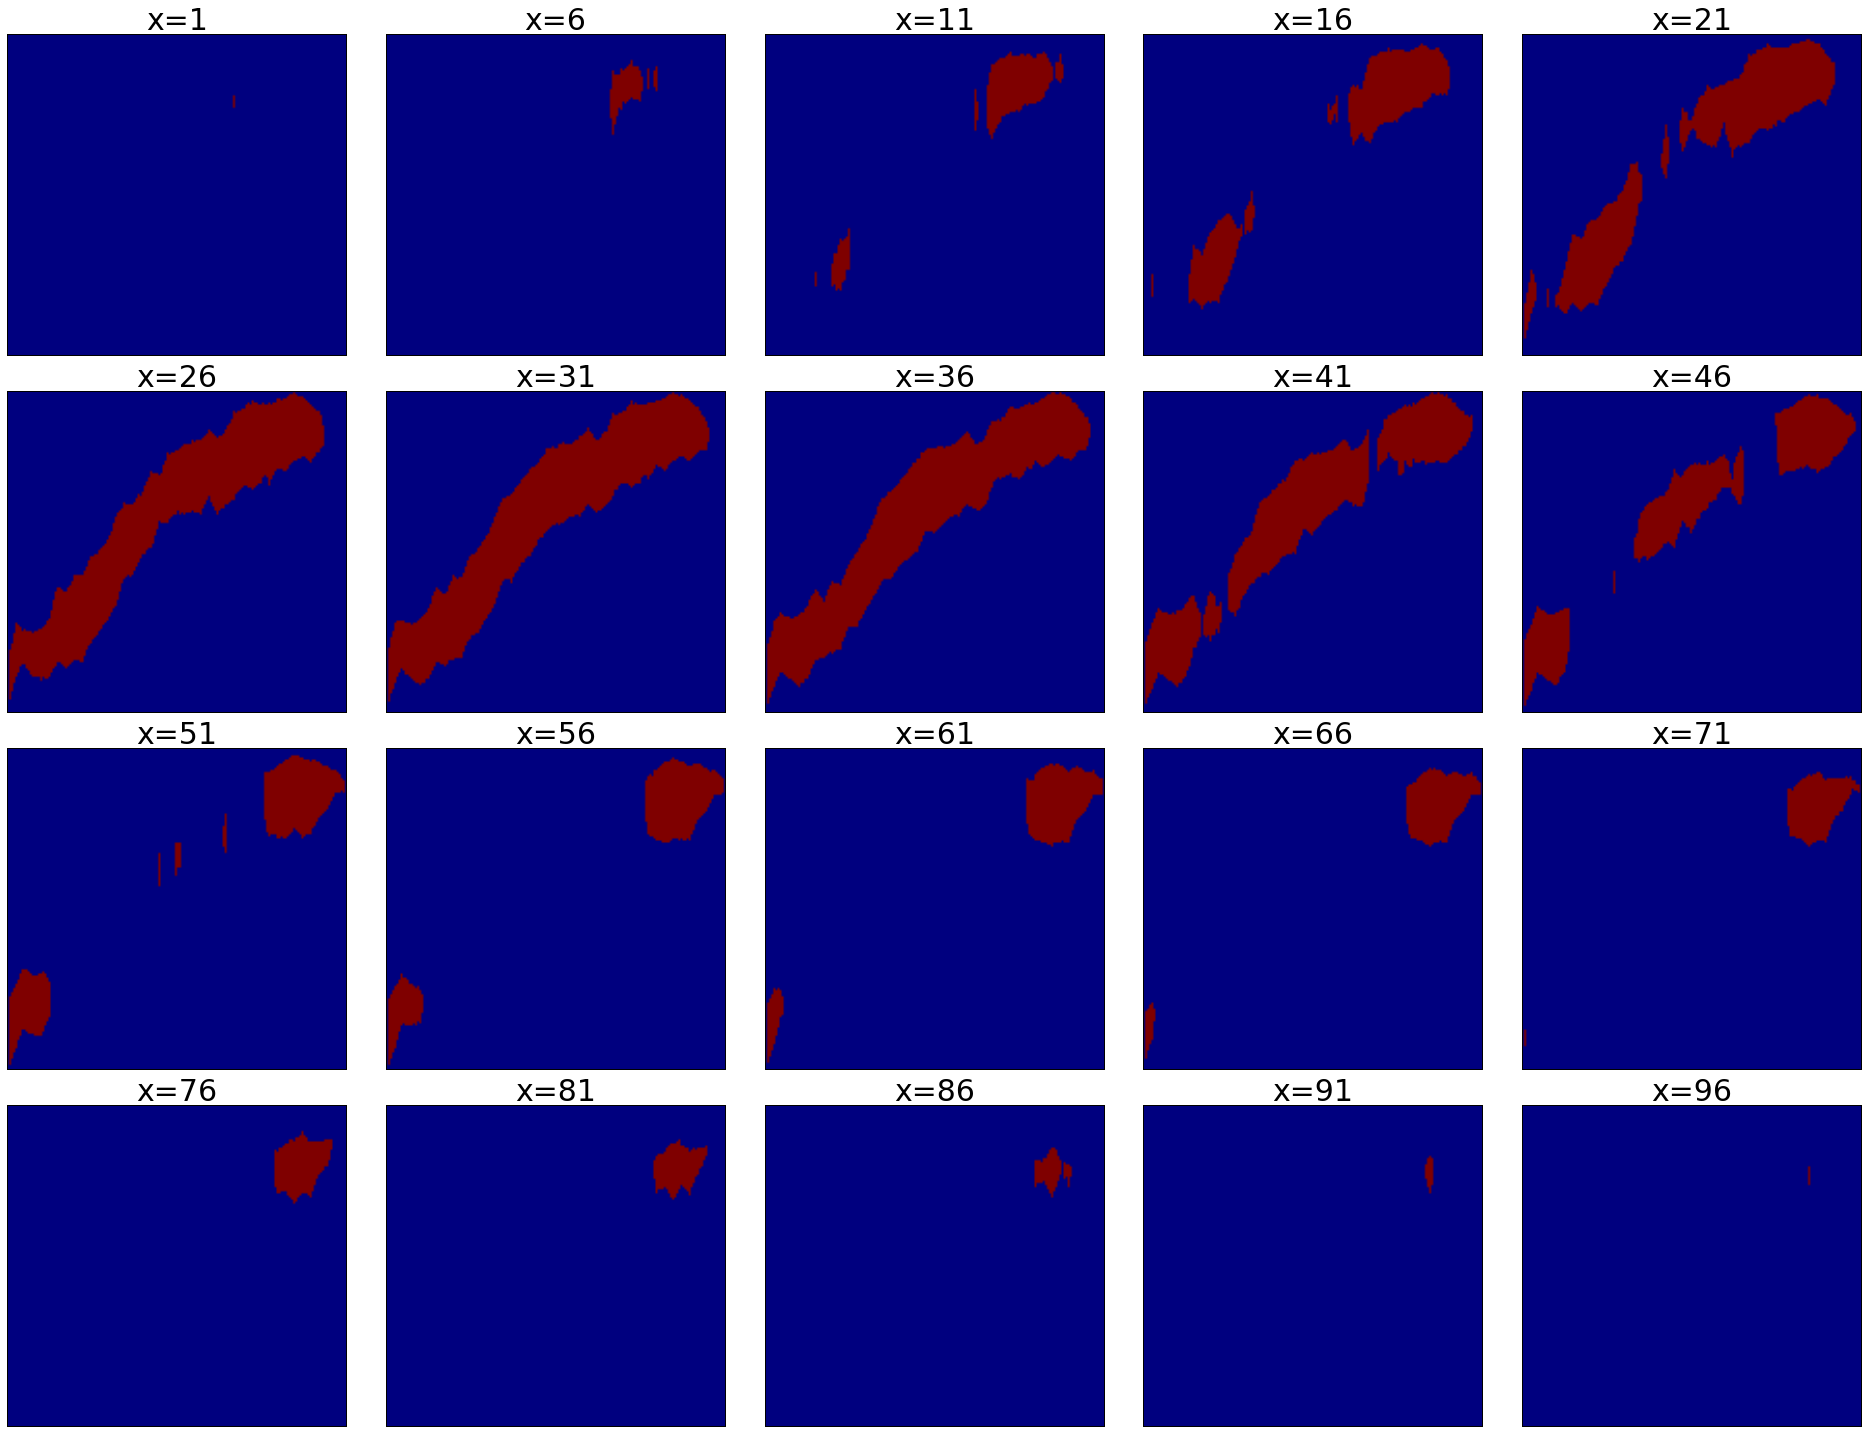

In [23]:
display_volume_sections(vol_bbox_dict['7n_L'][0], direction='x')

In [38]:
polydata_actor_list = []
for name_s in ['7n_R', '7n_L']:
    polydata = volume_to_polydata(vol_bbox_dict[name_s][0], num_simplify_iter=3, smooth=True)
    xmin, _, ymin, _, zmin, _ = vol_bbox_dict[name_s][1]
    polydata_actor = actor_mesh(polydata, origin=(xmin,ymin,zmin), wireframe=True, )
    polydata_actor_list.append(polydata_actor)

marching cube: 0.41 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 47217: 0.56 seconds
simplify 1 @ 9443: 0.49 seconds
simplify 2 @ 1888: 0.10 seconds
marching cube: 0.34 seconds
mesh_to_polydata: 0.05 seconds
simplify 0 @ 38311: 0.42 seconds
simplify 1 @ 7663: 0.33 seconds
simplify 2 @ 1534: 0.08 seconds


In [40]:
launch_vtk(polydata_actor_list + [actor_sphere(position=(0,0,0), radius=10)])

# Compute registration parameters.

# Visualize multiple co-registered brains.

Load fixed brain and another brain that has been transformed into alignment.

In [6]:
def get_stacy_markers_filepath(stack, structure):
    return os.path.join(STACY_DATA_ROOTDIR, 'markers', stack, stack + '_markers_%s.bp' % structure)

In [7]:
REGISTRATION_PARAMETERS_ROOTDIR = os.path.join(STACY_DATA_ROOTDIR, 'registration_parameters') # Change this to match your file organization.

def get_alignment_result_filepath_v2(stack_f, stack_m, warp_setting, what, ext=None,
                                  detector_id_m=None, detector_id_f=None,
                                  prep_id_m=None, prep_id_f=None,
                                  structure_f=None, structure_m=None,
                                  vol_type_f='score', vol_type_m='score',
                                  downscale=32, trial_idx=None):
    reg_basename = get_warped_volume_basename(**locals())
    if what == 'parameters':
        ext = 'json'
    elif what == 'scoreHistory' or what == 'trajectory':
        ext = 'bp'
    elif what == 'scoreEvolution':
        ext = 'png'
    elif what == 'parametersWeightedAverage':
        ext = 'pkl'
    fp = os.path.join(REGISTRATION_PARAMETERS_ROOTDIR, stack_m, reg_basename, reg_basename + '_' + what + '.' + ext)
    return fp

def load_alignment_parameters_v2(stack_f, stack_m, warp_setting,
                                  prep_id_m=None, prep_id_f=None,
                                  detector_id_m=None, detector_id_f=None,
                                  structure_f=None, structure_m=None,
                                  vol_type_f='score', vol_type_m='score',
                                  downscale=32, trial_idx=None):
    what = 'parameters'
    tf_param_fp = get_alignment_result_filepath_v2(**locals())
    return load_json(tf_param_fp)

In [8]:
VOLUME_ROOTDIR = os.path.join(STACY_DATA_ROOTDIR, 'volumes') # Change this to match your file organization.

In [9]:
def volume_type_to_str(t):
    if t == 'annotationAsScore':
        return 'annotationAsScoreVolume'
    else:
        raise Exception('Volume type %s is not recognized.' % t)
        
def get_original_volume_basename(stack, structure=None, volume_type='score', **kwargs):

    downscale = 32
    
    components = []
    if downscale is not None:
        components.append('down%(downscale)d' % {'downscale':downscale})
    tmp_str = '_'.join(components)

    basename = '%(stack)s_%(tmp_str)s_%(volstr)s' % \
        {'stack':stack, 'tmp_str':tmp_str, 'volstr':volume_type_to_str(volume_type)}
    if structure is not None:
        basename += '_' + structure
    return basename

def get_warped_volume_basename(stack_m,
                               stack_f=None,
                               warp_setting=None,
                               structure_m=None,
                               structure_f=None,
                               vol_type_m='score',
                               vol_type_f='score',
                               **kwargs):

    basename_m = get_original_volume_basename(stack=stack_m, volume_type=vol_type_m, structure=structure_m)

    if stack_f is None:
        assert warp_setting is None
        vol_name = basename_m
    else:
        basename_f = get_original_volume_basename(stack=stack_f, volume_type=vol_type_f, structure=structure_f)
        vol_name = basename_m + '_warp%(warp)d_' % {'warp':warp_setting} + basename_f

    return vol_name

def load_original_volume(stack, structure, volume_type=None):
    basename = get_original_volume_basename(stack=stack, volume_type=volume_type)
    vol_fp = os.path.join(VOLUME_ROOTDIR, '%(stack)s',
                          '%(basename)s',
                          'score_volumes',
                         '%(basename)s_%(struct)s.bp') % \
    {'stack':stack, 'basename':basename, 'struct':structure}
    
    volume = bp.unpack_ndarray_file(vol_fp).astype(np.float32)
    return volume

def load_original_volume_bbox(stack, structure, volume_type=None):
    basename = get_original_volume_basename(stack=stack, volume_type=volume_type)
    bbox_fp = os.path.join(VOLUME_ROOTDIR, '%(stack)s',
                          '%(basename)s',
                          'score_volumes',
                         '%(basename)s_%(struct)s_bbox.txt') % \
    {'stack':stack, 'basename':basename, 'struct':structure}
    
    volume_bbox = np.loadtxt(bbox_fp).astype(np.int)
    return volume_bbox    
    
def load_original_volume_all_known_structures_v2(stack,
                                                structures=None,
                                                sided=True,
                                                include_surround=False,
                                                 return_label_mappings=False,
                                                 name_or_index_as_key='name',
                                                 common_shape=True):
    """
    Load original (un-transformed) volumes for all structures and optionally normalize them into a common shape.

    Args:
        common_shape (bool): If true, volumes are normalized to the same shape.

    Returns:
        If `common_shape` is True:
            if return_label_mappings is True, returns (volumes, common_bbox, structure_to_label, label_to_structure), volumes is dict.
            else, returns (volumes, common_bbox).
        If `common_shape` is False:
            if return_label_mappings is True, returns (dict of volume_bbox_tuples, structure_to_label, label_to_structure).
            else, returns volume_bbox_tuples.
    """

    if structures is None:
        if sided:
            if include_surround:
                structures = all_known_structures_sided_with_surround
            else:
                structures = all_known_structures_sided
        else:
            structures = all_known_structures
        structures += ['Brainstem'] # Add for stacy data.

    loaded = False
    sys.stderr.write('Prior structure/index map not found. Generating a new one.\n')

    volumes = {}
    if not loaded:
        structure_to_label = {}
        label_to_structure = {}
        index = 1
    for structure in structures:
        try:

            if loaded:
                index = structure_to_label[structure]

            v = load_original_volume(stack=stack, structure=structure, volume_type='annotationAsScore')
            b = load_original_volume_bbox(stack=stack, structure=structure, volume_type='annotationAsScore')

            if name_or_index_as_key == 'name':
                volumes[structure] = (v,b)
            else:
                volumes[index] = (v,b)

            if not loaded:
                structure_to_label[structure] = index
                label_to_structure[index] = structure
                index += 1

        except Exception as e:
            sys.stderr.write('%s\n' % e)
            sys.stderr.write('Score volume for %s does not exist.\n' % structure)

    if common_shape:
        volumes_normalized, common_bbox = convert_vol_bbox_dict_to_overall_vol(vol_bbox_dict=volumes)

        if return_label_mappings:
            return volumes_normalized, common_bbox, structure_to_label, label_to_structure
        else:
            return volumes_normalized, common_bbox
    else:
        if return_label_mappings:
            return volumes, structure_to_label, label_to_structure
        else:
            return volumes
        
def load_transformed_volume(stack_m, stack_f,
                            warp_setting,
                            structure_f=None,
                            structure_m=None,
                            vol_type_m=None,
                            vol_type_f=None,
                            structure=None):
    basename = get_warped_volume_basename(**locals())
    if structure is not None:
        fn = basename + '_%s' % structure
    else:
        fn = basename
    fp = os.path.join(VOLUME_ROOTDIR, stack_m, basename, 'score_volumes', fn + '.bp')
    return bp.unpack_ndarray_file(fp)

def load_transformed_volume_bbox(stack_m, stack_f,
                                    warp_setting,
                                    structure_m=None,
                                    structure_f=None,
                                    vol_type_m='annotationAsScore',
                                    vol_type_f='annotationAsScore',
                                    structure=None,):
    basename = get_warped_volume_basename(**locals())
    if structure is not None:
        fn = basename + '_%s' % structure
    else:
        fn = basename
    fp = os.path.join(VOLUME_ROOTDIR, stack_m, basename, 'score_volumes', fn + '_bbox.txt')
    return np.loadtxt(fp)

In [10]:
stack_fixed = 'RV4_67hrs'

In [11]:
brain_fixed = load_original_volume_all_known_structures_v2(stack=stack_fixed, 
                                                            sided=True, 
                                                           include_surround=False, 
                                                           common_shape=False)

Prior structure/index map not found. Generating a new one.
[Errno 2] No such file or directory: '/home/yuncong/stacy_data/volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.
[Errno 2] No such file or directory: '/home/yuncong/stacy_data/volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.
[Errno 2] No such file or directory: '/home/yuncong/stacy_data/volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_L.bp'
Score volume for Amb_L does not exist.
[Errno 2] No such file or directory: '/home/yuncong/stacy_data/volumes/RV4_67hrs/RV4_67hrs_down32_annotationAsScoreVolume/score_volumes/RV4_67hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.
[Errno 2] No such file or directory: '/ho

In [12]:
# Convert volumes to meshes.

fixed_brain_meshes = {name_s: volume_to_polydata(brain_fixed[name_s][0], 
                                                 num_simplify_iter=0 if name_s == 'Brainstem' else 3, 
                                                 smooth=True) 
                      for name_s in brain_fixed.iterkeys()}

marching cube: 0.25 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 60212: 0.95 seconds
simplify 1 @ 12044: 0.61 seconds
simplify 2 @ 2410: 0.12 seconds
marching cube: 0.09 seconds
mesh_to_polydata: 0.04 seconds
simplify 0 @ 16538: 1.47 seconds
simplify 1 @ 3309: 0.15 seconds
simplify 2 @ 663: 0.03 seconds
marching cube: 0.46 seconds
mesh_to_polydata: 0.13 seconds
simplify 0 @ 97006: 1.13 seconds
simplify 1 @ 19402: 1.39 seconds
simplify 2 @ 3882: 0.37 seconds
marching cube: 0.23 seconds
mesh_to_polydata: 0.10 seconds
simplify 0 @ 37580: 0.85 seconds
simplify 1 @ 7517: 0.66 seconds
simplify 2 @ 1505: 0.13 seconds
marching cube: 0.15 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 23460: 0.48 seconds
simplify 1 @ 4693: 0.28 seconds
simplify 2 @ 940: 0.06 seconds
marching cube: 0.15 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 42142: 0.67 seconds
simplify 1 @ 8430: 0.44 seconds
simplify 2 @ 1687: 0.09 seconds
marching cube: 0.38 seconds
mesh_to_polydata: 0.06 seconds
simpl

In [13]:
# Create actors - adjust colors and other rendering options.
fixed_brain_actor_list = {name_s: actor_mesh(mesh, origin=brain_fixed[name_s][1][[0,2,4]], 
                                     wireframe=False if name_s == 'Brainstem' else True, 
                                     color=stacks_to_colors[stack_fixed],
                                    opacity=0.02 if name_s == 'Brainstem' else 1.) 
                          for name_s, mesh in fixed_brain_meshes.iteritems()}

In [14]:
# Load fixed brains markers.
fixed_brain_markers = bp.unpack_ndarray_file(get_stacy_markers_filepath(stack=stack_fixed, structure='All'))

In [15]:
fixed_brain_marker_actors = [actor_sphere((x,y,z), radius=2, color=stacks_to_colors[stack_fixed]) 
                             for x,y,z in fixed_brain_markers[::3]]

In [17]:
launch_vtk(fixed_brain_actor_list.values() \
           + fixed_brain_marker_actors
          )

In [19]:
# Load moving brains

In [24]:
moving_brain_actor_list_all_stacks = {}
moving_brain_outline_actor_all_stacks = {}

for stack_moving in ['RV14_65hrs', 'RV13_64hrs', 'RV19_61hrs']:
    
    print stack_moving

    brain_moving = \
    load_original_volume_all_known_structures_v2(stack=stack_moving, sided=True, 
                                                          include_surround=False,
                                                             common_shape=False)
    
    tf_parameter_dict = load_alignment_parameters_v2(stack_f=stack_fixed, stack_m=stack_moving, warp_setting=24, 
                                         vol_type_f='annotationAsScore', vol_type_m='annotationAsScore',
                                         downscale=32)
    cf = np.array(tf_parameter_dict['centroid_f'])
    cm = np.array(tf_parameter_dict['centroid_m'])
    of = np.array(tf_parameter_dict['crop_origin_f'])
    om = np.array(tf_parameter_dict['crop_origin_m'])
    params = np.array(tf_parameter_dict['params'])

    G_movingvol2fixedvol = consolidate(params=params, 
                                       centroid_m=cm, 
                                       centroid_f=cf)
    
    brain_movingAlignedToFixed = {}
    for name_s, (v, b) in brain_moving.iteritems():
            
        volume_m_warped_inbbox, volume_m_warped_bbox_rel2movingvol = \
        transform_volume_v3(vol=v, bbox=b-om[[0,0,1,1,2,2]], tf_params=G_movingvol2fixedvol[:3].flatten())

        volume_m_warped_bbox_rel2fixedvol = volume_m_warped_bbox_rel2movingvol
        volume_m_warped_bbox = volume_m_warped_bbox_rel2fixedvol + of[[0,0,1,1,2,2]]
    
        brain_movingAlignedToFixed[name_s] = (volume_m_warped_inbbox, volume_m_warped_bbox)
        
    moving_brain_meshes = {name_s: volume_to_polydata(brain_movingAlignedToFixed[name_s][0], 
                                                      num_simplify_iter=0 if name_s == 'Brainstem' else 3, 
                                                      smooth=True)
                           for name_s in brain_movingAlignedToFixed.iterkeys()}
    
    moving_brain_actor_list = {name_s: 
                               actor_mesh(mesh, origin=brain_movingAlignedToFixed[name_s][1][[0,2,4]], 
                                      wireframe=False if name_s == 'Brainstem' else True, 
                                          color=stacks_to_colors[stack_moving],
                                         opacity=0.02 if name_s == 'Brainstem' else 1.) 
                          for name_s, mesh in moving_brain_meshes.iteritems()}
    
    moving_brain_actor_list_all_stacks[stack_moving] = moving_brain_actor_list

RV14_65hrs


Prior structure/index map not found. Generating a new one.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV14_65hrs/RV14_65hrs_down32_annotationAsScoreVolume/score_volumes/RV14_65hrs_down32_annotationAsScoreVolume_LC_R.bp'
Score volume for LC_R does not exis

Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.00 seconds.
Interpolating/filling sparse volume: 0.01 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.03 seconds.
Interpolating/filling sparse volume: 0.12 seconds.
Interpolating/filling sparse volume: 5.07 seconds.
Interpolating/filling sparse volume: 0.05 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.09 seconds.
Interpolating/filling sparse volume: 0.17 seconds.
Interpolating/filling sparse volume: 0.01 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
marching cube: 0.28 seconds
mesh_to_polydata: 0.14 seconds
simplify 0 @ 49833: 1.08 seconds
simplify 1 @ 9961: 1.10 seconds
simplify 2 @ 1989: 0.28 seconds
marching cube: 0.02 seconds
mesh_to_polydata: 0.01 seconds
simplify 0 @ 2853: 0

RV13_64hrs


Prior structure/index map not found. Generating a new one.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV13_64hrs/RV13_64hrs_down32_annotationAsScoreVolume/score_volumes/RV13_64hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not ex

Interpolating/filling sparse volume: 0.11 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.05 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
Interpolating/filling sparse volume: 0.28 seconds.
Interpolating/filling sparse volume: 10.40 seconds.
Interpolating/filling sparse volume: 0.05 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.06 seconds.
Interpolating/filling sparse volume: 0.15 seconds.
Interpolating/filling sparse volume: 0.29 seconds.
Interpolating/filling sparse volume: 0.00 seconds.
Interpolating/filling sparse volume: 0.10 seconds.
marching cube: 0.47 seconds
mesh_to_polydata: 0.20 seconds
simplify 0 @ 62327: 1.45 seconds
simplify 1 @ 12463: 1.05 seconds
simplify 2 @ 2494: 0.23 seconds
marching cube: 0.14 seconds
mesh_to_polydata: 0.08 seconds
simplify 0 @ 23510

RV19_61hrs


Prior structure/index map not found. Generating a new one.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_6N_L.bp'
Score volume for 6N_L does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_6N_R.bp'
Score volume for 6N_R does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_Amb_R.bp'
Score volume for Amb_R does not exist.
[Errno 2] No such file or directory: '/media/yuncong/YuncongPublic/CSHL_volumes/RV19_61hrs/RV19_61hrs_down32_annotationAsScoreVolume/score_volumes/RV19_61hrs_down32_annotationAsScoreVolume_LC_L.bp'
Score volume for LC_L does not ex

Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.03 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
Interpolating/filling sparse volume: 0.10 seconds.
Interpolating/filling sparse volume: 0.33 seconds.
Interpolating/filling sparse volume: 9.23 seconds.
Interpolating/filling sparse volume: 0.02 seconds.
Interpolating/filling sparse volume: 0.08 seconds.
Interpolating/filling sparse volume: 0.04 seconds.
Interpolating/filling sparse volume: 0.10 seconds.
Interpolating/filling sparse volume: 0.00 seconds.
Interpolating/filling sparse volume: 0.07 seconds.
marching cube: 0.22 seconds
mesh_to_polydata: 0.09 seconds
simplify 0 @ 74056: 0.73 seconds
simplify 1 @ 14785: 0.79 seconds
simplify 2 @ 2979: 0.17 seconds
marching cube: 0.11 seconds
mesh_to_polydata: 0.06 seconds
simplify 0 @ 35401: 0.49 seconds
simplify 1 @ 7044: 0.38 seconds
simplify 2 @ 1402: 0.08 seconds
marching cube: 0.14 seco

In [25]:
# Markers

moving_brain_marker_aligned2fixed_actors_all_stacks = {}

for stack_moving in ['RV14_65hrs', 'RV13_64hrs', 'RV19_61hrs']:
    
    tf_parameter_dict = load_alignment_parameters_v2(stack_f=stack_fixed, stack_m=stack_moving, warp_setting=24, 
                                             vol_type_f='annotationAsScore', vol_type_m='annotationAsScore',
                                             downscale=32)
    cf = tf_parameter_dict['centroid_f']
    cm = tf_parameter_dict['centroid_m']
    of = tf_parameter_dict['crop_origin_f']
    om = tf_parameter_dict['crop_origin_m']
    params = tf_parameter_dict['params']
    Rt = np.reshape(params, (3,4))
    R = Rt[:3,:3]
    t = Rt[:3,3]

    moving_brain_markers = bp.unpack_ndarray_file(get_stacy_markers_filepath(stack=stack_moving, structure='All'))
    moving_brain_markers_aligned2fixed = np.dot(R, (moving_brain_markers - om - cm).T).T + t + of + cf
    moving_brain_marker_aligned2fixed_actors = [actor_sphere((x,y,z), radius=2, color=stacks_to_colors[stack_moving]) 
                                                for x,y,z in moving_brain_markers_aligned2fixed[::3]]
    
    moving_brain_marker_aligned2fixed_actors_all_stacks[stack_moving] = moving_brain_marker_aligned2fixed_actors

Render all brains in 3D.

In [28]:
launch_vtk(fixed_brain_actor_list.values() \
           + fixed_brain_marker_actors \
           + [a for actor_list in moving_brain_actor_list_all_stacks.values() for a in actor_list.values()] \
           + [a for actor_list in moving_brain_marker_aligned2fixed_actors_all_stacks.values() for a in actor_list] \
          ) 
# This origin is the one used by the points in the Neurolucida export files.